# Cosmology project: Measuring Cosmic acceleration with Type Ia Supernovaes

#### Authors: Oriol Abril Pla, Mariona Badenas Agusti

April 2018

# Introduction 

Import the libraries that will be used throughout the project.

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

import pandas as pd
import matplotlib.pyplot as plt

import scipy.optimize as opt
import scipy.integrate as pyint
import scipy.constants as const
import scipy.stats as stat
import numpy as np
import numpy.linalg as linalg

import emcee
print('emcee version', emcee.__version__, ', latest version 3.0.0')
import corner

import astropy.modeling.models as amod
import astropy.modeling.fitting as afit
import sys

from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 7
#rcParams['figure.figsize'] = 5.5, 3.2
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

emcee version 3.0.0.dev0 , latest version 3.0.0


## Load the data
Load the sample from Union2 SNe and select only the desired SN's (by applying a mask based on "Cuts_failed", which is explained in more detail on our presentation). 

In [3]:
database_file = 'data/SCPUnion2.1_AllSNe.txt'
SNe_df = pd.read_csv(
    database_file,
    header=None,
    sep=r'\)?\s+&\s+',
    engine='python',
    na_filter=['\nodata', '\nodata\\'],
    names=[
        'ID', 'z', 'mb', 'x1', 'color', 'd_mod', 'unknown', 'sample',
        'Cuts Failed'
    ]).set_index('ID')

SNe_df['Cuts Failed'] = SNe_df['Cuts Failed'].str.slice(stop=-2)
SNe_df.info()
SNe_df = SNe_df[SNe_df['Cuts Failed'] == '\\nodata']
SNe_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 753 entries, 1993ah to X-026
Data columns (total 8 columns):
z              753 non-null float64
mb             753 non-null object
x1             753 non-null object
color          753 non-null object
d_mod          753 non-null object
unknown        753 non-null object
sample         753 non-null float64
Cuts Failed    753 non-null object
dtypes: float64(2), object(6)
memory usage: 52.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 580 entries, 1993ah to Z-005
Data columns (total 8 columns):
z              580 non-null float64
mb             580 non-null object
x1             580 non-null object
color          580 non-null object
d_mod          580 non-null object
unknown        580 non-null object
sample         580 non-null float64
Cuts Failed    580 non-null object
dtypes: float64(2), object(6)
memory usage: 40.8+ KB


In [4]:
def split_errors(df,name): # Small snippet code to extract the errors from the data (the original format was weird)
    #print df.loc[df[name]==na][name]
    mask = df[name].str.slice(start=-6)=='nodata'
    df.loc[mask, name] = 'NaN(NaN'
    split_df = df[name].str.split('(',expand=True)
    df[name] = split_df[0].astype(float)
    df['err_{}'.format(name)] = split_df[1].astype(float)
split_errors(SNe_df,'mb')
split_errors(SNe_df,'x1')
split_errors(SNe_df,'color')
split_errors(SNe_df,'d_mod')
nice_columns = ['z', 'mb', 'err_mb',  'color', 'err_color',
                           'd_mod', 'err_d_mod', 'x1', 'err_x1']
SNe_df = SNe_df[nice_columns]
SNe_df.head()

,z,mb,err_mb,color,err_color,d_mod,err_d_mod,x1,err_x1
ID,,,,,,,,,
1993ah,0.0285,16.86,0.19,0.23,0.09,35.35,0.22,-2.26,0.93
1993ag,0.0500,17.79,0.05,0.12,0.02,36.68,0.17,-1.09,0.24
1993o,0.0529,17.60,0.05,-0.01,0.02,36.82,0.16,-1.03,0.14
1993b,0.0701,18.43,0.04,0.09,0.02,37.45,0.16,-0.53,0.21
1992bs,0.0627,18.25,0.05,0.02,0.02,37.48,0.16,-0.27,0.23


## Load covariance matrices

There are two types of covariances: the "systematics" and the "non systematics" one. 

In [5]:
C_sys = np.loadtxt('data/SCPUnion2.1_covmat_sys.txt')
Cinv_sys = linalg.inv(C_sys)
C_nosys = np.loadtxt('data/SCPUnion2.1_covmat_nosys.txt')
sigma_ext2 = np.diag(C_nosys)

## Define cosmological functions

The following functions allow us to calculate parameters such as the comoving distance $\chi$, the distance luminosity $D_{L}$, the distance modulus $\mu$, and the Hubble parameter $H(z)$ for different models of the Universe. 

In [6]:
def chi(zvec,Hz_fun,args):
    chi = const.c/1000*np.array([pyint.quad(lambda zz: 1./Hz_fun(zz,*args),0,z)[0] for z in zvec])
    return chi

def dist_lum(z,Hz_fun,args):
    return chi(z,Hz_fun,args)*(1+z)

def dist_mod(z,Hz_fun,args):
    D_L = dist_lum(z,Hz_fun,args)
    return 5*np.log10(D_L)+25

def Hz_flatLCDM(z,Ode,H0=73.8):
    '''
    Flat Lambda-CDM model with H0 from Riess 2016 and k=0 fixed
    '''
    Om = 1-Ode
    Hz = H0*np.sqrt(Om*(1+z)**3+Ode)
    return Hz

def Hz_curvedLCDM(z,Om,Ode,H0=73.8):
    '''
    Curved Lambda-CDM model with H0 from Riess 2016 and k not fixed
    '''
    Ok = 1-Om-Ode
    Hz = H0*np.sqrt(Om*(1+z)**3+Ok*(1+z)**2+Ode)
    return Hz

def Hz_w_cte(z,Ode,w,H0=73.8):
    Om = 1-Ode
    Hz = H0*np.sqrt(Om*(1+z)**3+Ode*np.exp(3*(1+w)*np.log(1+z)))
    return Hz

# Plot Hubble diagram

Having obtained the distance modulus, we can now generate the Hubble diagram at different redshifts.

Text(0,0.5,'Distance modulus')

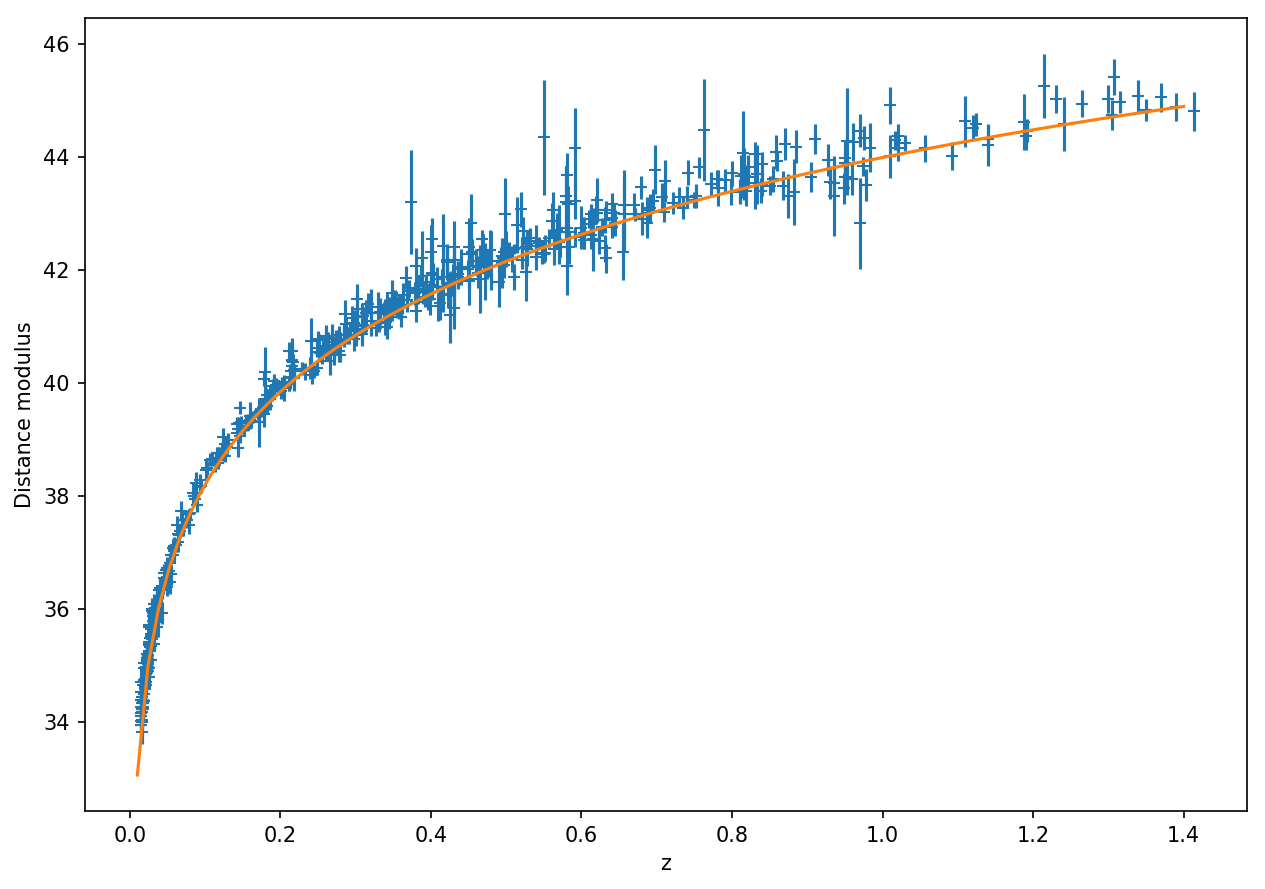

In [7]:
z_grid = np.linspace(1e-2,1.4,100)
plt.errorbar(SNe_df['z'],SNe_df['d_mod'],yerr=SNe_df['err_d_mod'],fmt='_',zorder=0)
plt.plot(z_grid,dist_mod(z_grid,Hz_flatLCDM,(0.7,)),zorder=1)
plt.xlabel('z'); plt.ylabel('Distance modulus')

## Hubble diagram (+ zoom to linear)
The following lines of code show how the data plotted above does not allow for a proper calculation of $H_0$. The procedure to try $H_0$ calculation is to filter the SNe sample to get the low redshift subset, and make a linear fit to it. The slope will be an aproximation of $H_0$

In [8]:
# Convert z to v and d_mod to distance luminosity
v_SNe = const.c/1000.*SNe_df['z']
dL_SNe = 10**((SNe_df['d_mod']-25+2.5*np.log10(1+SNe_df['z']))/5)
# Select only low redshift/distance data
dL_max = 120
v_SNe=v_SNe[dL_SNe<dL_max]
dL_SNe=dL_SNe[dL_SNe<dL_max]
# fit both with an intercept and forcing v = H*dL
H0_fit, intercept, r, p, err = stat.linregress(dL_SNe,v_SNe)
H0_curvefit = opt.curve_fit(lambda d,H: H*d, dL_SNe, v_SNe, p0=70)[0][0]

In [9]:
age_fit = 1/H0_fit*1e6*3.86e13/3.154e7/1e9
age_curvefit = 1/H0_curvefit*1e6*3.86e13/3.154e7/1e9
print('The value of H0 forcing v(z=0)=0 is H0 = {} km/s/Mpc,\nwhich means \
an aproximate age of the universe of {} Myr'.format(H0_curvefit,age_curvefit))
print('\nThe value of H0 NOT forcing v(z=0) is H0 = {0} km/s/Mpc with v(z=0) = {1} km/s,\n\
which means an aproximate age of the universe of {2} Myr'.format(H0_fit,intercept,age_fit))

The value of H0 forcing v(z=0)=0 is H0 = 68.2734485943133 km/s/Mpc,
which means an aproximate age of the universe of 17.92560306497399 Myr

The value of H0 NOT forcing v(z=0) is H0 = 61.273112853853675 km/s/Mpc with v(z=0) = 646.8468011535952 km/s,
which means an aproximate age of the universe of 19.973568868577484 Myr


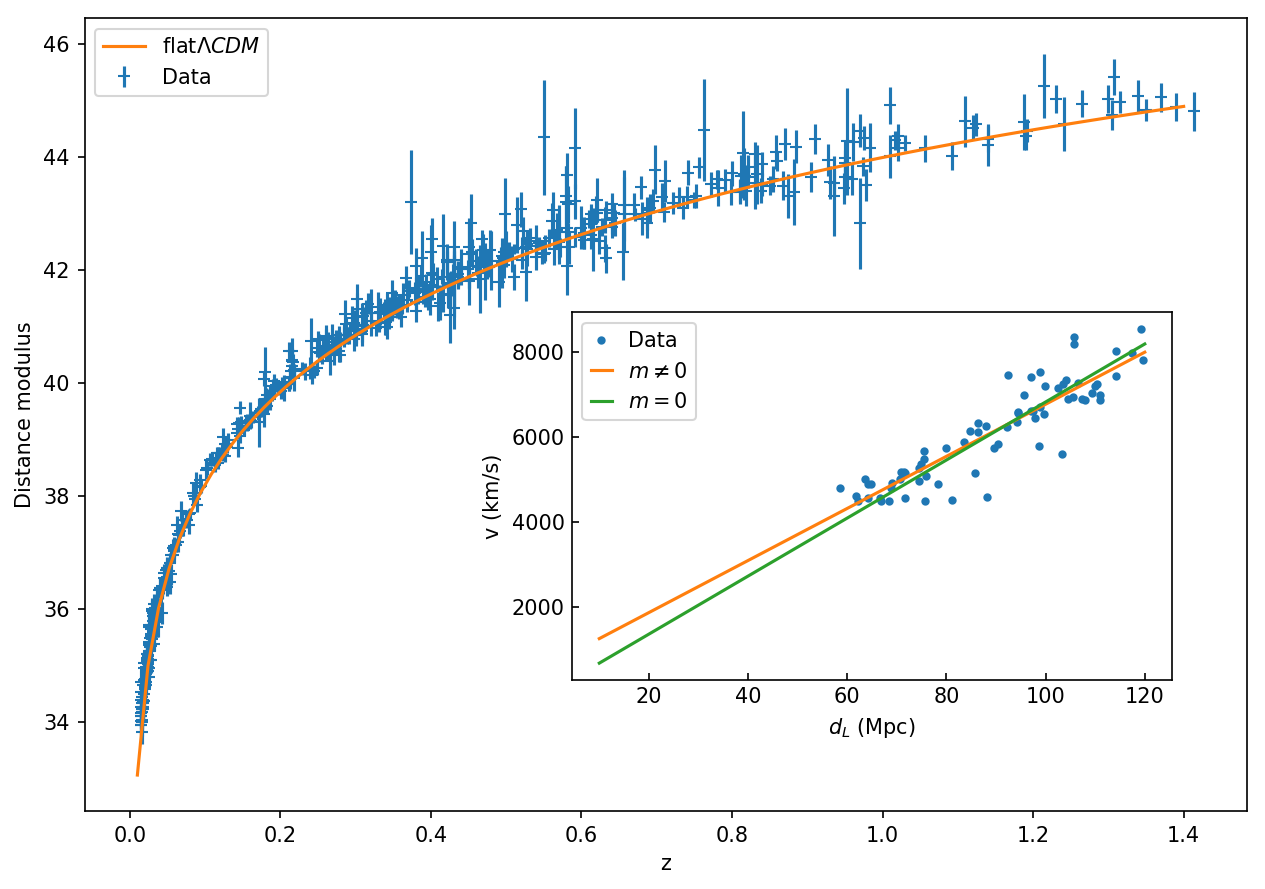

In [10]:
fig = plt.figure(); ax = fig.add_subplot(111)
ax.errorbar(SNe_df['z'],SNe_df['d_mod'],yerr=SNe_df['err_d_mod'],fmt='_',label='Data',zorder=0)
ax.plot(z_grid,dist_mod(z_grid,Hz_flatLCDM,(0.7,)),label='flat$\Lambda CDM$',zorder=1)
ax.set_xlabel('z'); ax.set_ylabel('Distance modulus')
ax.legend()

dL_grid = np.linspace(10,120)
zoom_ax = fig.add_axes([.45,.25,.4,.35])
zoom_ax.plot(dL_SNe,v_SNe,'.',label='Data')
zoom_ax.plot(dL_grid,dL_grid*H0_fit+intercept,label=r'$m\neq 0$')
zoom_ax.plot(dL_grid,dL_grid*H0_curvefit,label='$m= 0$')
zoom_ax.set_xlabel('$d_L$ (Mpc)'); zoom_ax.set_ylabel('v (km/s)')
zoom_ax.tick_params(direction='in')
zoom_ax.legend(handlelength=1)

# Find cosmological parameters 

We will study three models of the Universe: 

 A. Flat Universe, $w = 0$
 
 B. Curved Universe, $w = 0$
 
 C. Flat Universe, $w\neq0$

## A. Flat universe and w=0

### Approach 1: Fit with distance modulus from Union 2.1 Table

In [11]:
# Create astropy model
flatLCDM_aModel = amod.custom_model(lambda z,Ode=.7 : dist_mod(z,Hz_flatLCDM,(Ode,)))
 
init_flatLCDM = flatLCDM_aModel()
fit_flatLCDM = afit.LevMarLSQFitter()
flatLCDM_result = fit_flatLCDM(init_flatLCDM,
                               SNe_df['z'],
                               SNe_df['d_mod'],
                               weights=1/SNe_df['err_d_mod'])
flatLCDM_Ode_err = np.sqrt(np.diag(fit_flatLCDM.fit_info['param_cov']))[0]
Ode_flat = flatLCDM_result.Ode.value
Om_flat = 1-Ode_flat

In [12]:
print('The fitted values are:\n\tOm : {0:.3f}({2:.2f})\n\tOde : {1:.3f}({2:.2f})'.format(1-Ode_flat,Ode_flat,flatLCDM_Ode_err))

The fitted values are:
	Om : 0.145(0.01)
	Ode : 0.855(0.01)


Use equation 3.48 of the cosmology notes to compute the value of the cosmic deceleration (today).

In [13]:
q0_std = (1-Ode_flat)/2-Ode_flat
q0_error = np.sqrt(5)*flatLCDM_Ode_err/2
print('The deceleration parameter is {:.4f}({:.3g})'.format(q0_std,q0_error))

The deceleration parameter is -0.7830(0.013)


####  $\chi^2$ comparison 
Plot the obtained $\chi^2$ for the standard fit to show that the weird value is not due to  a problem with the minimizer. Two different values of $H_0$ are compared.

In [14]:
Ode_grid = np.linspace(0,1,201)
Ode_chi_73 = [sum((SNe_df['d_mod']-dist_mod(SNe_df['z'],Hz_flatLCDM,(Ode,73.8)))**2/SNe_df['err_d_mod']) 
           for Ode in Ode_grid]
Ode_chi_69 = [sum((SNe_df['d_mod']-dist_mod(SNe_df['z'],Hz_flatLCDM,(Ode,69)))**2/SNe_df['err_d_mod']) 
           for Ode in Ode_grid]

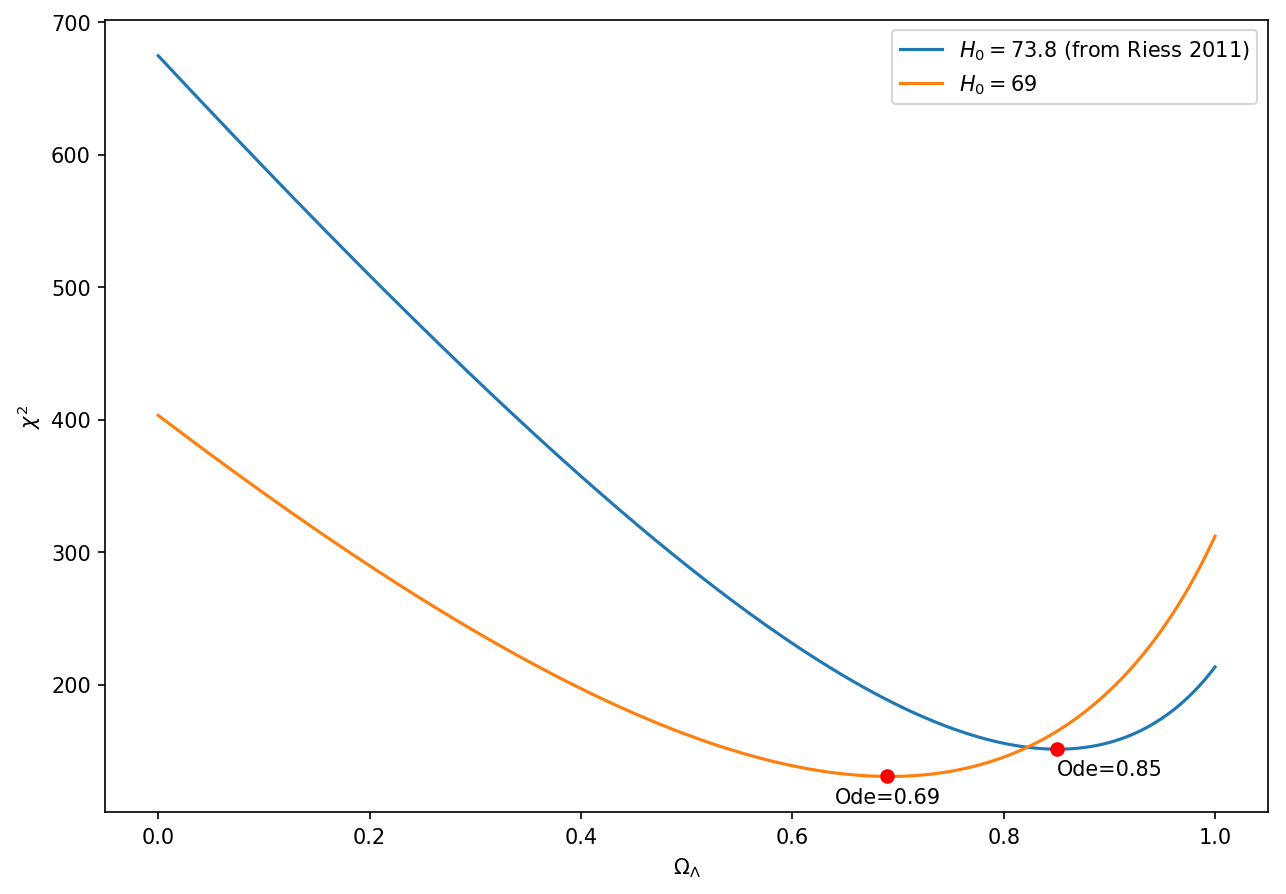

In [15]:
plt.plot(Ode_grid,Ode_chi_73,label=r'$H_0=73.8$ (from Riess 2011)')
plt.plot(Ode_grid,Ode_chi_69,label=r'$H_0=69$')
plt.xlabel(r'$\Omega_\Lambda$'); plt.ylabel(r'$\chi^2$')
plt.legend()
ind_73 = np.argmin(Ode_chi_73)
inds_73 = np.argsort(Ode_chi_73)
plt.plot(Ode_grid[ind_73],Ode_chi_73[ind_73],'ro')
plt.text(Ode_grid[ind_73],Ode_chi_73[ind_73]-20,'Ode={:.2f}'.format(Ode_grid[ind_73]))
ind_69 = np.argmin(Ode_chi_69)
plt.plot(Ode_grid[ind_69],Ode_chi_69[ind_69],'ro')
plt.text(Ode_grid[ind_69]-.05,Ode_chi_69[ind_69]-20,'Ode={:.2f}'.format(Ode_grid[ind_69]))
plt.savefig('chi2_Ode.png')

### Approach 2: Consider nuisance parameters

####  2.1. $\chi^2$ minimization.

In [16]:
def chi2_sys_flatLCDM(x,data=SNe_df,Csys=C_sys, Cext = C_nosys, Cinv_sys=Cinv_sys):
    alfa,beta,Mb,Ode = x
    Om = 1-Ode
    mu_B = data['mb']+alfa*data['x1']-beta*data['color']-Mb
    mu_cosmo = dist_mod(data['z'],Hz_flatLCDM,(Ode,))
    mu_diff = (mu_B-mu_cosmo)**2
    sigma2_lc = data['err_mb']**2+alfa**2*data['err_x1']**2+beta**2*data['err_color']**2
    Cinv = linalg.inv(np.diag(sigma2_lc)+Csys)
    #Cinv = linalg.inv(Csys)
    #Cinv = linalg.inv(np.diag(sigma2_lc)+Csys+Cext)
    res = np.matmul(mu_diff,np.matmul(Cinv,mu_diff))
    return res

Minimize the $\chi^2$, using $\alpha=0.08$, $\beta=2.4$, $M_{b}=-19.1$, $\Omega_{\Lambda}=.71$ as initial guesses. 

In [17]:
chi2_sys_lc_res = opt.minimize(chi2_sys_flatLCDM,(0.08,2.4,-19.1,.71))
Ode_sys_lc = chi2_sys_lc_res['x'][-1]

Compute the uncertainties of our best fit results using the $\chi^2$, we use 
$$\Delta \chi^2 = -1 \quad \Rightarrow \quad \Delta \chi^2 = \chi^2(\theta_{ML})-\chi^2(\theta_{ML}\pm \hat{\sigma_{\theta_{ML}}})$$

In [17]:
chi2_sys_lc_fixed_nuis = lambda x: chi2_sys_flatLCDM([*chi2_sys_lc_res['x'][:-1],x])-chi2_sys_lc_res['fun']-1
Ode_sys_lc_p_error = opt.fsolve(chi2_sys_lc_fixed_nuis,
                                Ode_sys_lc + .1)[0] - Ode_sys_lc
Ode_sys_lc_m_error = Ode_sys_lc - opt.fsolve(chi2_sys_lc_fixed_nuis,
                                             Ode_sys_lc - .1)[0]

In [18]:
Ode_chi_sys_lc = [chi2_sys_flatLCDM([*chi2_sys_lc_res['x'][:-1],Ode]) for Ode in Ode_grid]

Plot the $\chi^2$ as a function of $\Omega_{\Lambda}$ (in blue) and compare the results with those obtained with Approach 1 (in green). 

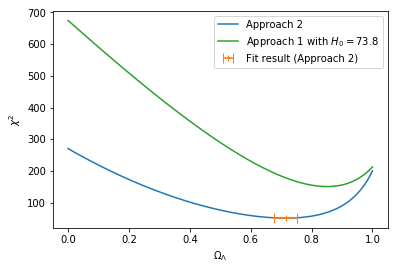

In [19]:
plt.plot(Ode_grid, Ode_chi_sys_lc, label='Approach 2', zorder=-1)
plt.errorbar(
    Ode_sys_lc,
    chi2_sys_flatLCDM([*chi2_sys_lc_res['x'][:-1], Ode_sys_lc]),
    xerr=np.array([[Ode_sys_lc_m_error], [Ode_sys_lc_p_error]]),
    fmt='+',
    capsize=5,
    zorder=1,
    label='Fit result (Approach 2)')
plt.plot(Ode_grid, Ode_chi_73, label=r'Approach 1 with $H_0=73.8$', zorder=-1)
#plt.plot(Ode_grid,Ode_chi_69,label=r'$H_0=69$')
plt.xlabel(r'$\Omega_\Lambda$')
plt.ylabel(r'$\chi^2$')
plt.legend()

In [20]:
print('The chi2 with nuisance parameters fit yields:\n\tOm = {0:.3g}(-{2:.2g},+{3:.2g})\n\t\
Ode = {1:.3g}(-{2:.2g},+{3:.2g})\nWith \
nuisance parameters:\n\talpha = {4:.3g}\n\tbeta = {5:.3g}\n\tM = {6:.3f}'.format(1-Ode_sys_lc,Ode_sys_lc,
                                                                  Ode_sys_lc_m_error,
                                                                  Ode_sys_lc_p_error,
                                                                  *chi2_sys_lc_res['x'][:-1]))

The chi2 with nuisance parameters fit yields:
	Om = 0.286(-0.039,+0.036)
	Ode = 0.714(-0.039,+0.036)
With nuisance parameters:
	alpha = 0.0859
	beta = 2.39
	M = -19.130


Calculate the value of the cosmic deceleration. 

In [21]:
# using equation 3.48 of the cosmology notes
q0_sys_lc = (1-Ode_sys_lc)/2-Ode_sys_lc
sigma = np.sqrt(Ode_sys_lc_m_error**2+Ode_sys_lc_p_error**2)
q0_err_sys_lc = np.sqrt(5)*sigma/2
print('The deceleration parameter is {:.3f}({:.2g}).'.format(q0_sys_lc,q0_err_sys_lc))

The deceleration parameter is -0.572(0.059).


#### 2.2. Instead of doing $\chi^2$ minimization, apply Bayesian statistics with MCMC

Prepare the necessary functions for the MCMC (a log likelihood function, and then two possible prior functions --one using linear and the other logarithmic priors)).

In [22]:
def lnprior(theta):
    if 0 < theta[3] < 1:
        return 0.0
    return -np.inf

def ln_logprior(theta):
    if theta[3] < 0:
        return -np.inf
    return -np.log(theta[3])

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - chi2_sys_flatLCDM(theta)

Initialize the MCMC with the appropiate number of dimensions and walkers, as well as with the initial conditions.

In [25]:
ndim, nwalkers = 4, 100
initMC_flat = np.array([0.1,2.5,-19.3,.3])
pos = [initMC_flat + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler_flat = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
sampler_flat.run_mcmc(pos, 1500, progress=True);

100%|██████████| 1500/1500 [2:28:50<00:00,  5.88s/it] 


Plot the results of the MCMC.

['$\\alpha$ = ${0.09}_{-0.01}^{+0.01}$', '$\\beta$ = ${2.40}_{-0.08}^{+0.08}$', '$M_b$ = ${-19.13}_{-0.03}^{+0.03}$', '$\\Omega_\\Lambda$ = ${0.71}_{-0.04}^{+0.04}$']


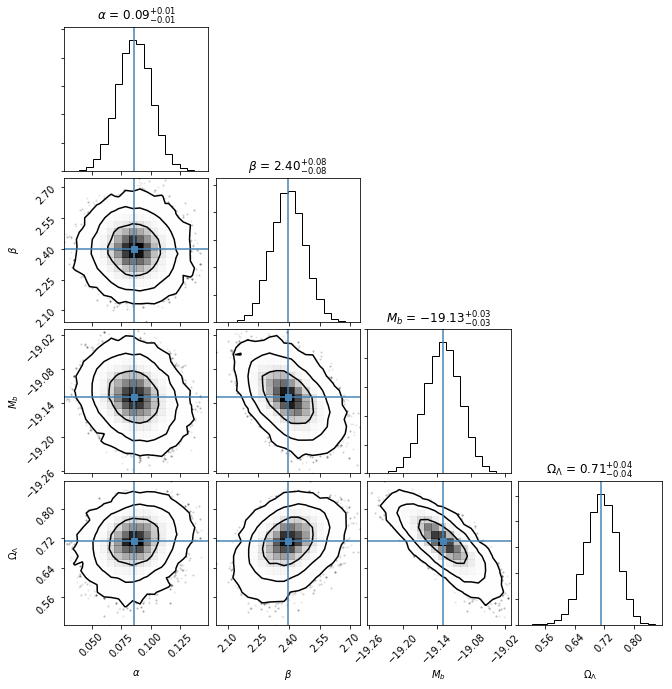

In [44]:
#samples_flat = sampler_flat.chain[:, 100:, :].reshape((-1, ndim))
samples_flat = np.loadtxt('samples/samples_flat.dat')
chi2_sys_lc_res_flat, chi2_sys_lc_err_flat = np.mean(samples_flat,axis=0),np.std(samples_flat,axis=0)
fig = corner.corner(samples_flat, labels=[r"$\alpha$", r"$\beta$", r"$M_b$", r"$\Omega_\Lambda$"],
                    truths=np.percentile(samples_flat,50,axis=0),show_titles=True,
                    levels=[.68,.95,.997])
print([ax.get_title() for ax in fig.axes if ax.get_title()!=''])

In [45]:
flat_truths = np.percentile(samples_flat,50,axis=0)
mu_nuis_flat = SNe_df['mb']+flat_truths[0]*SNe_df['x1']-flat_truths[1]*SNe_df['color']-flat_truths[2]

In [27]:
np.savetxt('samples/samples_flat.dat',samples_flat)

## B. Curved universe (w=0)
### Approach 1: Fit with distance modulus from Union 2.1 Table

In [28]:
# Create astropy model
curvedLCDM_aModel = amod.custom_model(lambda z,Om=0.3,Ode=.7 : dist_mod(z,Hz_curvedLCDM,(Om,Ode)))
 
init_curvedLCDM = curvedLCDM_aModel()
fit_curvedLCDM = afit.LevMarLSQFitter()
#init_curvedLCDM.Om.bounds = [0,1.]
#init_curvedLCDM.Ode.bounds = [0,1.]
curvedLCDM_result = fit_curvedLCDM(init_curvedLCDM,
                               SNe_df['z'],
                               SNe_df['d_mod'],
                               weights=1/SNe_df['err_d_mod'])

curvedLCDM_err = np.sqrt(np.diag(fit_curvedLCDM.fit_info['param_cov']))
Ode_curved = curvedLCDM_result.Ode.value
Om_curved = curvedLCDM_result.Om.value

In [29]:
print('The fitted values are:\n\tOm  : {:.3f}({:.2f})\n\tOde : {:.3f}({:.2f})\n\tOk  : {:.3f}({:.2f})'.format(Om_curved,curvedLCDM_err[0],
                                                                                     Ode_curved,curvedLCDM_err[1],1-Om_curved-Ode_curved,
                                                                                    np.sqrt(np.sum(curvedLCDM_err**2))))

The fitted values are:
	Om  : 1.324(0.19)
	Ode : 1.827(0.15)
	Ok  : -2.152(0.24)


In [30]:
# using equation 3.48 of the cosmology notes
q0_std_curved = Om_curved/2-Ode_curved
q0_err_std_curved = np.sqrt(curvedLCDM_err[0]**2/4+curvedLCDM_err[1]**2)
print('The deceleration parameter is {:.3f}({:.2g})'.format(q0_std_curved,
                                                     q0_err_std_curved))

The deceleration parameter is -1.165(0.17)


### Approach 2: Consider nuisance parameters
#### Use Bayesian statistics with MCMC

In [67]:
def chi2_sys_curvedLCDM(x, data=SNe_df,Csys=C_sys, Cext = C_nosys, Cinv_sys=Cinv_sys):
    alfa,beta,Mb,Om,Ode = x
    Ok = max(0,1-Om-Ode)
    mu_B = data['mb']+alfa*data['x1']-beta*data['color']-Mb
    mu_cosmo = dist_mod(data['z'],Hz_curvedLCDM,(Om,Ode))
    mu_diff = (mu_B-mu_cosmo)**2
    sigma2_lc = data['err_mb']**2+alfa**2*data['err_x1']**2+beta**2*data['err_color']**2
    Cinv = linalg.inv(np.diag(sigma2_lc)+Csys+Cext)
    #Cinv = Cinv_sys
    res = np.matmul(mu_diff,np.matmul(Cinv,mu_diff))
    return res

def lnprior_curved(theta):
    if 0 < theta[3] < 1 and 0 < theta[4] < 1:
        return 0.0
    return -np.inf

def ln_logprior_curved(theta):
    if theta[3] < 0 and theta[4] < 0:
        return -np.inf
    return -np.sum(np.log(theta[3:]))

def ln_wideprior_curved(theta):
    if 0 < theta[3] <2 and 0 < theta[4] < 3:
        return 0.0
    return -np.inf

def lnprob_curved(theta):
    lp = ln_wideprior_curved(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - chi2_sys_curvedLCDM(theta)

In [68]:
# MCMC parameters
ndim, nwalkers = 5, 100
initMC_curved = np.array([0.1,2.5,-19.3,.3,.7])
pos = [initMC_curved + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler_curved = emcee.EnsembleSampler(nwalkers, ndim, lnprob_curved)
sampler_curved.run_mcmc(pos, 1500, progress=True);

100%|██████████| 1500/1500 [2:35:36<00:00,  6.08s/it] 


['$\\alpha$ = ${0.08}_{-0.02}^{+0.02}$', '$\\beta$ = ${2.35}_{-0.10}^{+0.10}$', '$M_b$ = ${-19.12}_{-0.04}^{+0.04}$', '$\\Omega_m$ = ${0.33}_{-0.22}^{+0.21}$', '$\\Omega_\\Lambda$ = ${0.74}_{-0.22}^{+0.18}$']


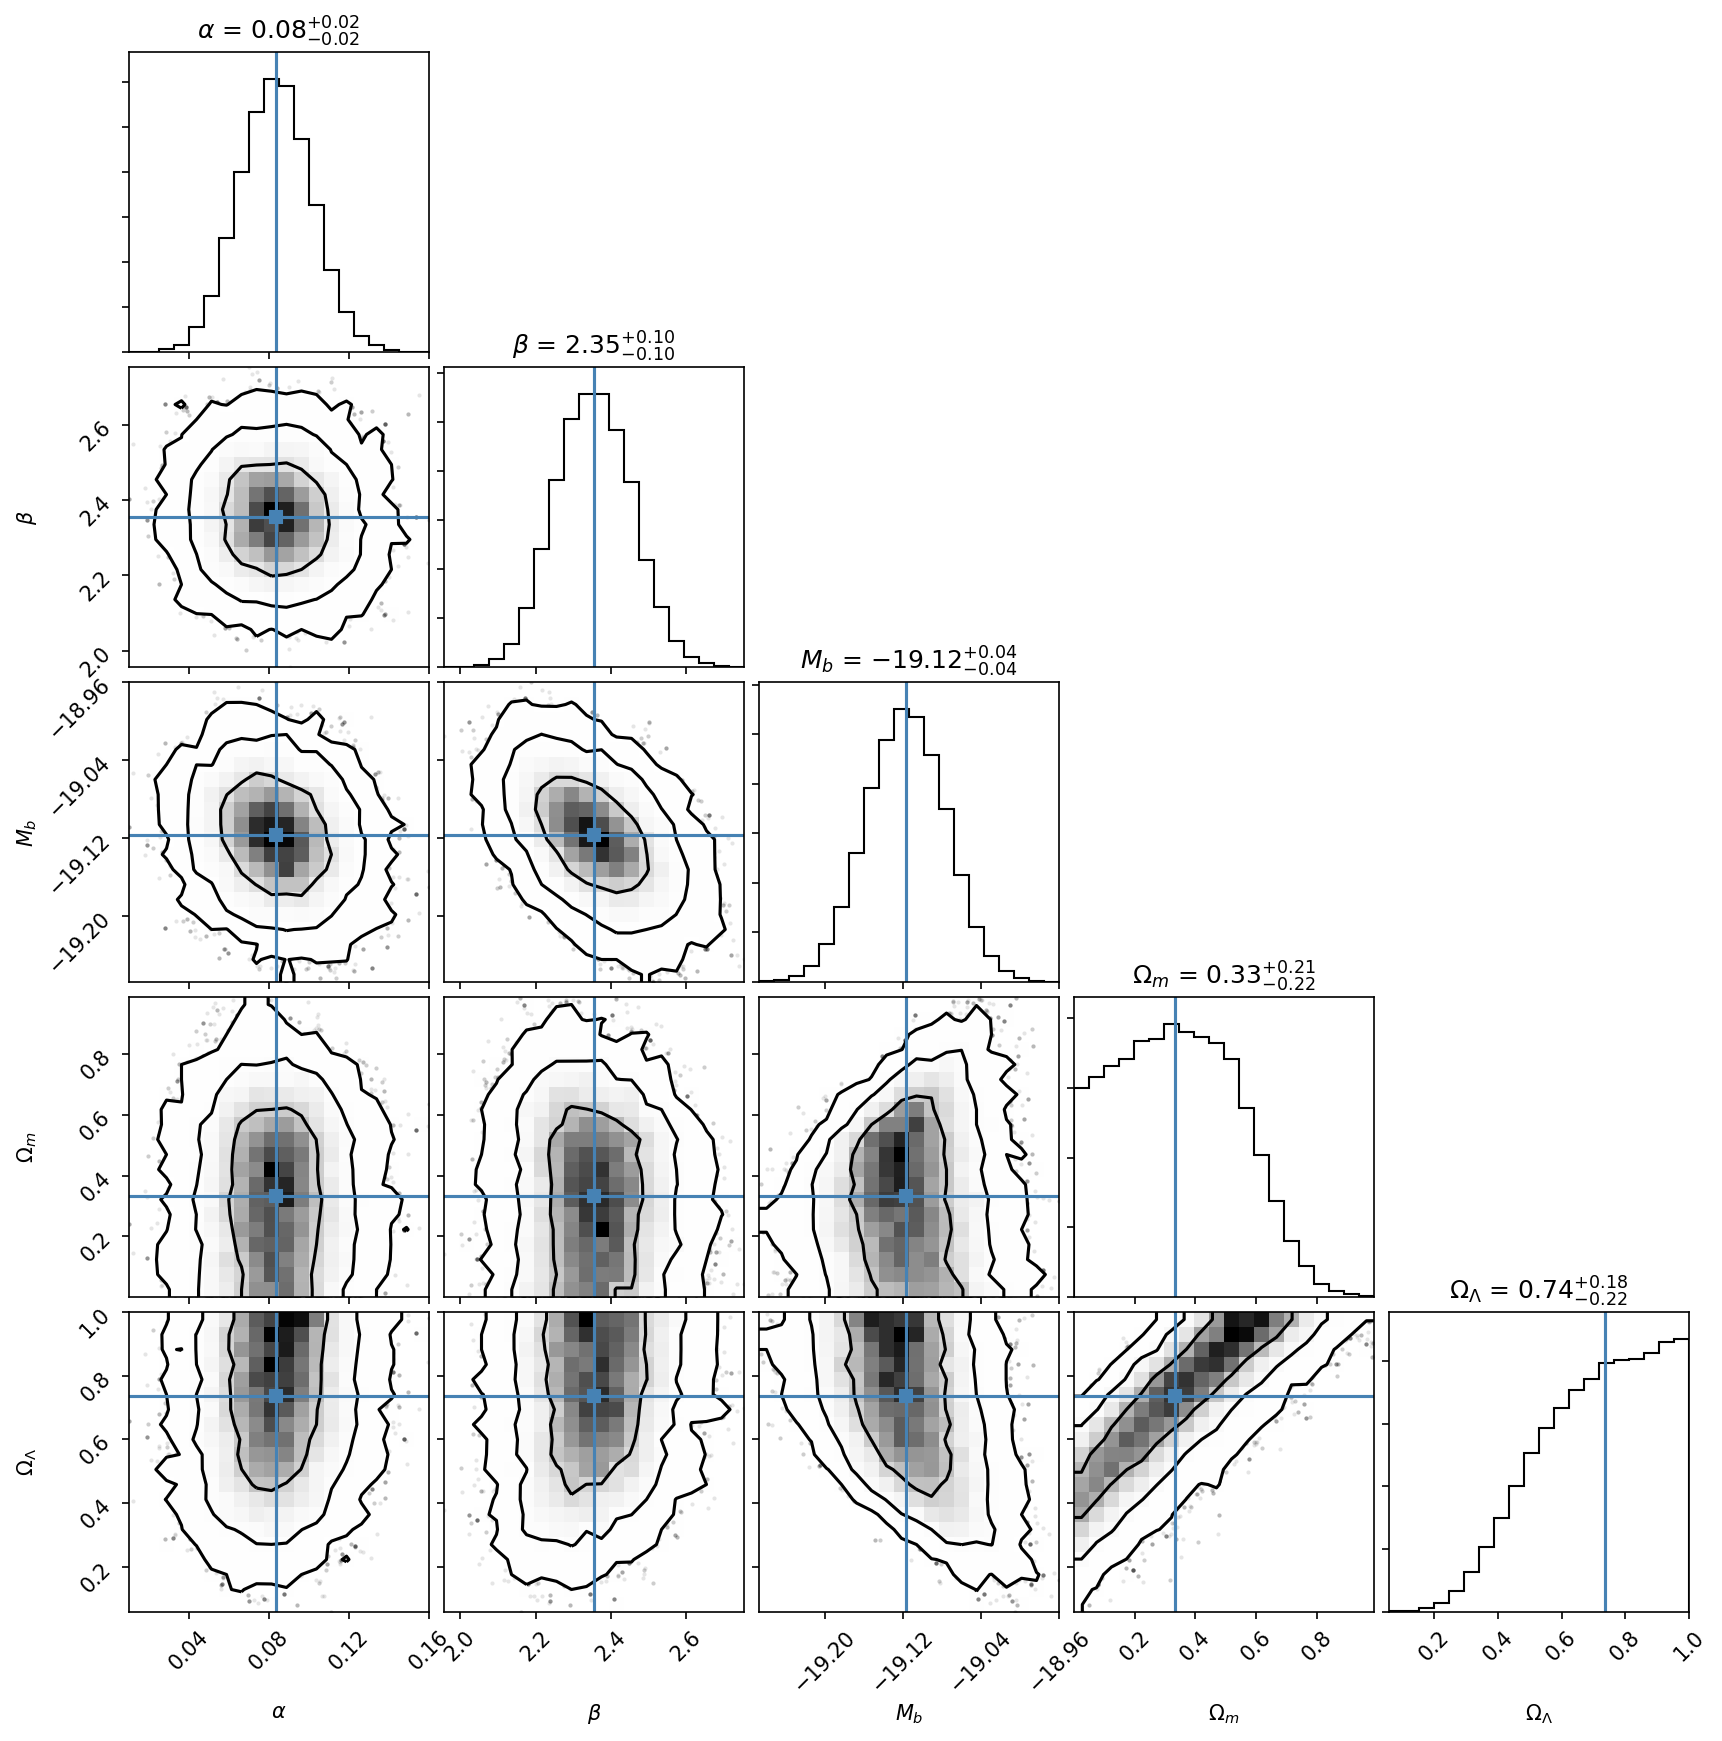

In [43]:
#samples_curved = sampler_curved.chain[:, 100:, :].reshape((-1, ndim))
samples_curved = np.loadtxt('samples/samples_curved.dat')
chi2_sys_lc_res_curved, chi2_sys_lc_err_curved = np.mean(samples_curved,axis=0),np.std(samples_curved,axis=0)
fig = corner.corner(samples_curved, labels=[r"$\alpha$", r"$\beta$", r"$M_b$", r"$\Omega_m$", r"$\Omega_\Lambda$"],
                    truths=np.percentile(samples_curved,50,axis=0),show_titles=True,
                    levels=[.68,.95,.997])
plt.savefig('curvedUni_w0.eps')

In [78]:
truths = np.percentile(samples_curved,50,axis=0)

Om_curved_mcmc = truths[3]
Ode_curved_mcmc = truths[4]
Ok_curved_mcmc = 1-Om_curved_mcmc-Ode_curved_mcmc

q16, q50, q84 = np.percentile(samples_curved, [16,50,84], axis = 0)
e_down = q50-q16; e_up = q84-q50

Ok_err_res_d = np.sqrt(np.sum(e_down[3:]**2))
Ok_err_res_u = np.sqrt(np.sum(e_up[3:]**2))
print(Ok_err_res_d, Ok_err_res_u)

q0_curved_mcmc = Om_curved_mcmc/2-Ode_curved_mcmc
q0_err_curved_mcmc_u = np.sqrt(e_up[3]**2/4+e_up[4]**2)
q0_err_curved_mcmc_d  = np.sqrt(e_down[3]**2/4+e_down[4]**2)

print('The deceleration parameter is {:.3f}(+{:.2g},-{:0.2g})'.format(q0_curved_mcmc,
                                                     q0_err_curved_mcmc_u,q0_err_curved_mcmc_d))

0.3091509252239142 0.28171907435356386
The deceleration parameter is -0.568(+0.21,-0.25)


In [70]:
np.savetxt('samples/samples_curved_wideprior.dat',samples_curved)

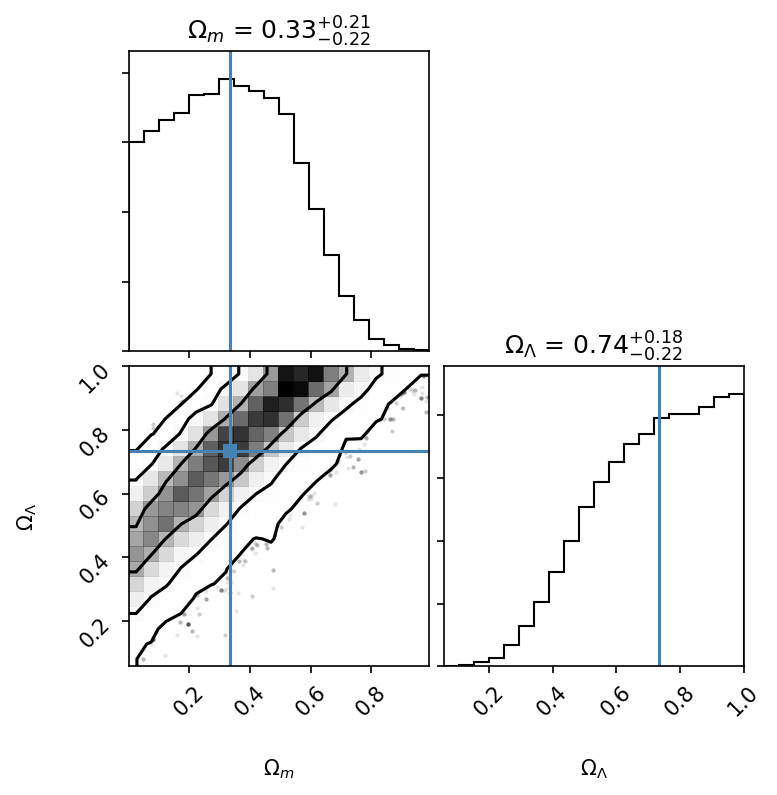

In [23]:
fig = corner.corner(samples_curved[:,3:], labels=[r"$\Omega_m$", r"$\Omega_\Lambda$"],
                    truths=np.percentile(samples_curved[:,3:],50,axis=0),show_titles=True,
                    levels=[.68,.95,.997])

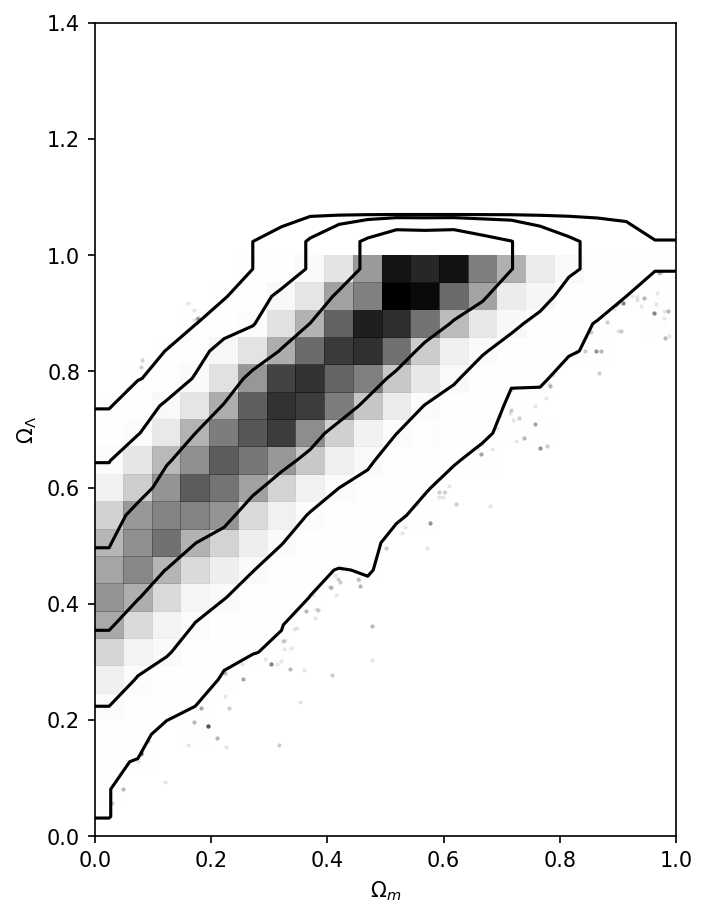

In [40]:
plt.figure(figsize=(5,10))
ax = plt.gca()
corner.hist2d(samples_curved[:,3],samples_curved[:,4],levels=[.68,.95,.997])
ax.set_xlim([0,1]); ax.set_ylim([0,1.4]); ax.set_aspect('equal')
ax.set_xlabel(r"$\Omega_m$"); ax.set_ylabel(r"$\Omega_\Lambda$")

plt.savefig('curvedUni_w0_zoom.eps')

## C. Calculate $w$, the dark matter equation of state parameter for a flat universe
### Approach 1: Fit with distance modulus from Union 2.1 Table

In [35]:
# Create astropy model
w_cte_aModel = amod.custom_model(lambda z,Ode=.3,w=-1 : dist_mod(z,Hz_w_cte,(Ode,w)))
 
init_w_cte = w_cte_aModel()
fit_w_cte = afit.LevMarLSQFitter()
w_cte_result = fit_w_cte(init_w_cte,
                               SNe_df['z'],
                               SNe_df['d_mod'],
                               weights=1/SNe_df['err_d_mod'])
w_cte_err = np.sqrt(np.diag(fit_w_cte.fit_info['param_cov']))
Om_w_cte = w_cte_result.Ode.value
Ode_w_cte = 1-Om_w_cte

In [36]:
print('The fitted values are:\n\tOm : {0:.3f}({2:.2f})\n\tOde : {1:.3f}({2:.2f})\n\tw : \
{3:.2f}({4:.2f})'.format(Om_w_cte,Ode_w_cte,
                       w_cte_err[0],
                       w_cte_result.w.value,
                       w_cte_err[1]))

The fitted values are:
	Om : 0.567(0.02)
	Ode : 0.433(0.02)
	w : -2.43(0.22)


In [37]:
# using equation 3.48 of the cosmology notes
q0_std_w_cte = Om_w_cte/2-Ode_w_cte
q0_err_std_w_cte = np.sqrt(w_cte_err[0]**2/4+w_cte_err[0]**2)
print('The deceleration parameter is {:.3f}({:.2g})'.format(q0_std_w_cte,
                                                     q0_err_std_w_cte))

The deceleration parameter is -0.150(0.024)


### Approach 2: Consider nuisance parameters
#### Use Bayesian statistics with MCMC

In [63]:
def chi2_sys_wLCDM(x, data=SNe_df,Csys=C_sys, Cext = C_nosys, Cinv_sys=Cinv_sys):
    alfa,beta,Mb,Ode,w = x
    Om = 1-Ode
    mu_B = data['mb']+alfa*data['x1']-beta*data['color']-Mb
    mu_cosmo = dist_mod(data['z'],Hz_w_cte,(Ode,w))
    mu_diff = (mu_B-mu_cosmo)**2
    sigma2_lc = data['err_mb']**2+alfa**2*data['err_x1']**2+beta**2*data['err_color']**2
    Cinv = linalg.inv(np.diag(sigma2_lc)+Csys)
    res = np.matmul(mu_diff,np.matmul(Cinv,mu_diff))
    return res

def lnprior_w(theta):
    if 0 < theta[3] < 1:
        return 0.0
    return -np.inf

def ln_logprior_w(theta):
    if theta[3] < 0:
        return -np.inf
    return -np.log(theta[3])

def lnprob_w(theta):
    lp = ln_logprior_w(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - chi2_sys_wLCDM(theta)

In [53]:
# MCMC parameters
ndim, nwalkers = 5, 100
initMC_curved = np.array([0.1,2.5,-19.3,.7,-1])
pos = [initMC_curved + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler_w = emcee.EnsembleSampler(nwalkers, ndim, lnprob_w)
sampler_w.run_mcmc(pos, 1500, progress=True);

100%|██████████| 1500/1500 [4:07:03<00:00,  9.72s/it]  


[  0.08766714   2.43435711 -19.15131371   0.67411833  -1.17782139]
['$\\alpha$ = ${0.09}_{-0.02}^{+0.02}$', '$\\beta$ = ${2.43}_{-0.09}^{+0.10}$', '$M_b$ = ${-19.15}_{-0.05}^{+0.04}$', '$\\Omega_\\Lambda$ = $0.67_{-0.08}^{+0.10}$', '$w$ = $-1.18_{-0.50}^{+0.35}$']


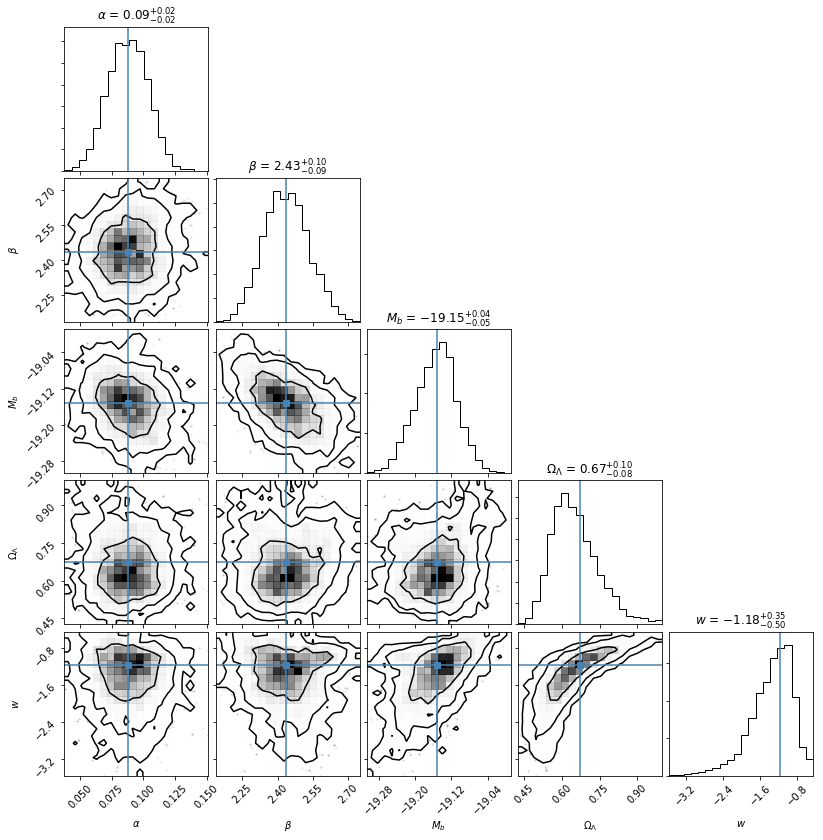

In [91]:
#samples_w = sampler_w.chain[:, 100:, :].reshape((-1, ndim))
samples_w = np.loadtxt('samples/samples_w_cte.dat')
H, xedges, yedges = np.histogram2d(samples_w[:,3],samples_w[:,4],bins=15)
ind_w = np.unravel_index(np.argmax(H),H.shape)
truths_w = np.percentile(samples_w,50,axis=0)
truths_w[3] = (xedges[ind_w[0]]+xedges[ind_w[0]+1])/2
truths_w[4] = (yedges[ind_w[1]]+yedges[ind_w[1]+1])/2
print(truths_w)
chi2_sys_lc_res_w, chi2_sys_lc_err_w = np.mean(samples_w,axis=0),np.std(samples_w,axis=0)
fig = corner.corner(samples_w, labels=[r"$\alpha$", r"$\beta$", r"$M_b$", r"$\Omega_\Lambda$", r'$w$'],
                    truths=truths,show_titles=True,levels=[.68,.95,.997])
# titles to change -1 and -7
axs = fig.axes
axs[-1].set_title('$w$ = ${:.2f}_{{-0.50}}^{{+0.35}}$'.format(truths[-1]))
axs[-7].set_title('$\\Omega_\\Lambda$ = ${:.2f}_{{-0.08}}^{{+0.10}}$'.format(truths[-2]))
plt.savefig('corner_w.eps')
print([ax.get_title() for ax in fig.axes if ax.get_title()!=''])

In [48]:
mu_nuis_w = SNe_df['mb']+truths[0]*SNe_df['x1']-truths[1]*SNe_df['color']-truths[2]

NameError: name 'samples_w' is not defined

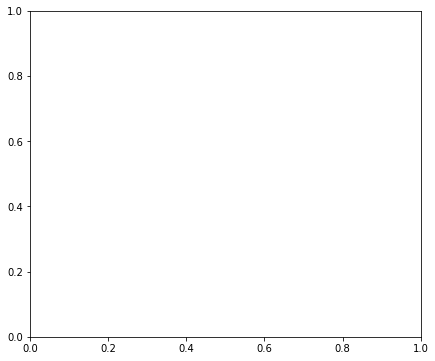

In [54]:
plt.figure(figsize=(7,8))
ax = plt.gca()
corner.hist2d(1-samples_w[:,3],samples_w[:,4],levels=[.68,.95,.997])
ax.set_xlim([0,0.5]); ax.set_ylim([-1.5,0]); #ax.set_aspect('equal')
ax.set_ylabel(r"$w$"); ax.set_xlabel(r"$\Omega_m$")
plt.savefig('corner_w_zoom.eps')

In [93]:
np.savetxt('samples/samples_w_cte_logprior.dat',samples_w)

In [94]:
print(truths_w)

Ode_w_mcmc = truths_w[3]
Om_w_mcmc = 1 - Ode_w_mcmc
w_mcmc = truths_w[4]

print(Ode_w_mcmc,Om_w_mcmc, w_mcmc)

e_w_down = q50_w-q16_w; e_w_up = q84_w-q50_w
print("Errors of Om and Ode (down, up):", e_w_down[3],e_w_up[3])
print("Errors of w (down, up):",e_w_down[4],e_w_up[4])

q0_w_mcmc = Om_w_mcmc/2-Ode_w_mcmc
q0_err_w_mcmc_u = np.sqrt(e_w_up[3]**2/4+e_w_up[3]**2)
q0_err_w_mcmc_d  = np.sqrt(e_w_down[3]**2/4+e_w_down[3]**2)

print('The deceleration parameter is {:.3f}(+{:.2g},-{:0.2g})'.format(q0_w_mcmc,
                                                     q0_err_w_mcmc_u,q0_err_w_mcmc_d))

[  0.08766714   2.43435711 -19.15131371   0.67411833  -1.17782139]
0.6741183313489851 0.32588166865101487 -1.1778213916610036
Errors of Om and Ode (down, up): 0.0752078375542855 0.1042782009005555
Errors of w (down, up): 0.4970290418436121 0.3456720660556284
The deceleration parameter is -0.511(+0.12,-0.084)


## Study the effect of Peculiar Velocities

In [9]:
def chi2_sys_flatLCDM_xerr(x,sigma_vsn=300,data=SNe_df,Csys=C_sys, Cext = C_nosys, Cinv_sys=Cinv_sys):
    alfa,beta,Mb,Ode = x
    Om = 1-Ode
    mu_B = data['mb']+alfa*data['x1']-beta*data['color']-Mb
    mu_cosmo = dist_mod(data['z'],Hz_flatLCDM,(Ode,))
    mu_diff = (mu_B-mu_cosmo)**2
    sigma2_lc = data['err_mb']**2+alfa**2*data['err_x1']**2+beta**2*data['err_color']**2
    sigma2_z_bar = ((1+data['z'])/const.c*1000)**2*sigma_vsn**2
    Cinv = linalg.inv(np.diag(sigma2_lc+sigma2_z_bar)+Csys)
    res = np.matmul(mu_diff,np.matmul(Cinv,mu_diff))
    return res

def lnprior(theta):
    if 0 < theta[3] < 1:
        return 0.0
    return -np.inf

def lnprob(theta,sigma_vsn):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - chi2_sys_flatLCDM_xerr(theta,sigma_vsn=sigma_vsn)

In [ ]:
# Physical parameters
sigma_vsn = 200000.

# MCMC parameters
ndim, nwalkers = 4, 100
initMC_flat = np.array([0.1,2.5,-19.3,.7])
pos = [initMC_flat + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler_xerr = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(sigma_vsn,))
sampler_xerr.run_mcmc(pos, 1500, progress=True);

  4%|▍         | 60/1500 [06:05<2:25:04,  6.05s/it]

In [ ]:
samples_xerr = sampler_xerr.chain[:, 100:, :].reshape((-1, ndim))
#samples_xerr = np.loadtxt('samples/samples_flat_xerr.dat')
fig = corner.corner(samples_xerr, labels=[r"$\alpha$", r"$\beta$", r"$M_b$", r"$\Omega_\Lambda$"],
                      truths=np.percentile(samples_xerr,50,axis=0),show_titles=True,levels=[.68,.95,.997])

In [ ]:
np.savetxt('samples/samples_flat_xerr_vsn{:.0f}.dat'.format(sigma_vsn),samples_xerr)